# Structure Inside Argon Plated MCM-41 Nanopores

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import pi as π
from scipy.constants import hbar as ħ
from scipy.constants import k as kb
from collections import defaultdict
import pickle

# local modules
import include.colors as colortools
from heprops import helium
from include.pimchelp import PIMCResults

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('./include/notebook.mplstyle')

## Parameters

In [2]:
T = np.array([1.6,4.2]) #K
τ = 0.004 # (1/K)
L = 50 # Å
Ro = 15.51 # Å
Ri = Ro - 3.71 # Å
P0 = helium.pressure_SVP(T)
data_dir = '../../../Data/Nanopores/'

## Grab, Process and Load Results

In [3]:
process = False
if process:
    for cT in T[1:]:
        %run /Users/agdelma/Documents/UVM/Projects/SCRIPTS/reduce-one.py -r u -T {cT} -L {L} -t {τ} --estimator=estimator $base_dir

### A key for temperature

In [4]:
def Tkey(T):
    return f'T = {T:3.1f} K'

### Chemical Potential vs. Reduced Pressure

In [5]:
x = np.linspace(1E-16,1,1000)

μ_exp = {}
for i,cT in enumerate(T):
    μ_exp[Tkey(cT)] = helium.chemical_potential(x*P0[i],T[i])

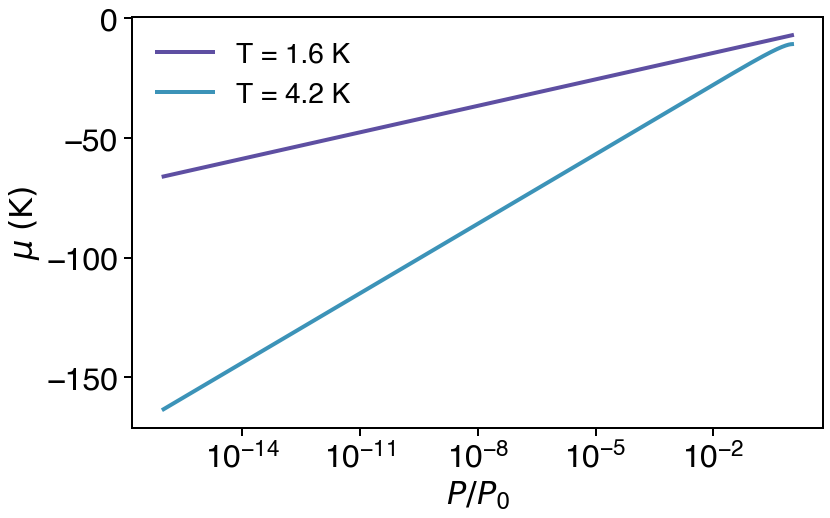

In [6]:
for i,cT in enumerate(T):
    plt.plot(x,μ_exp[Tkey(cT)], label=Tkey(cT))

plt.ylabel(r'$\mu\; (\mathrm{K})$')
plt.xlabel(r'$P/P_0$')
plt.xscale('log')
plt.legend()

## Investigate the Filling of the Pore

In [7]:
est,x,μ = {},{},{}

for i,cT in enumerate(T):
    est[Tkey(cT)] = PIMCResults('../Data/estimator-u-reduce-T-{:06.3f}-t-0.00400-L-050.000.dat'.format(cT))
    μ[Tkey(cT)] = est[Tkey(cT)].data['u']
    x[Tkey(cT)] = helium.pressure(est[Tkey(cT)].data['u'],cT)/helium.pressure_SVP(cT)

colors = colortools.get_linear_colors('Spectral',len(μ[Tkey(T[0])]),reverse=False)
Tcolors = {Tkey(T[0]):colors[-10],Tkey(T[1]):colors[10]}

Text(0.5, 0, '$P/P_0$')

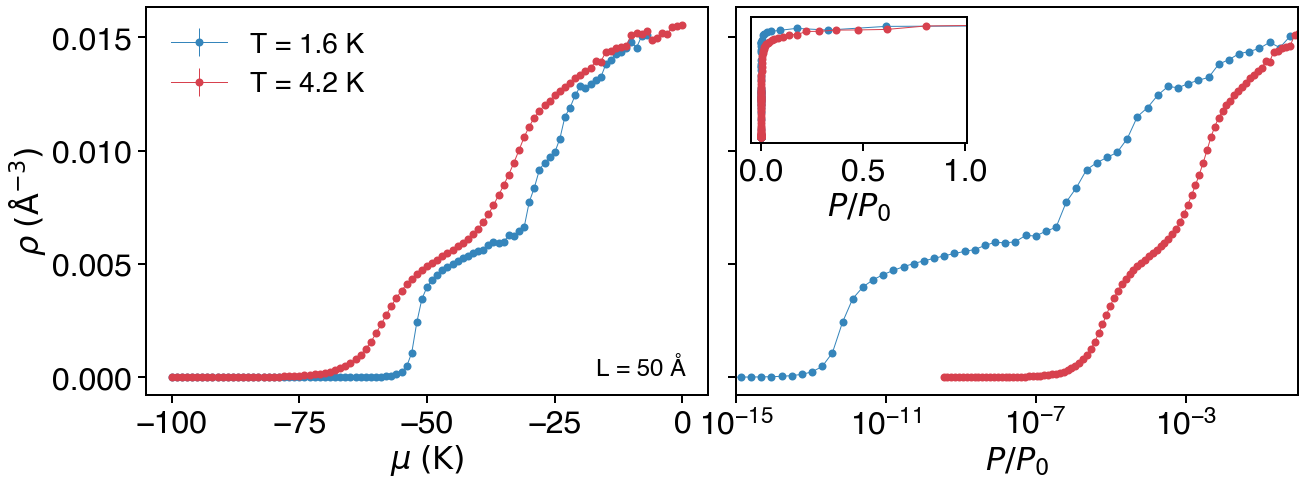

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker

fig, axes = plt.subplots(1,2,sharex=False, sharey=True, squeeze=True, figsize=(10,3.5))
fig.subplots_adjust(wspace=0.05)

for i,cT in enumerate(T):
    cest = est[Tkey(cT)]
    axes[0].errorbar(cest.data['u'],cest.data['density'],yerr=cest.data['Δdensity'], 
                     marker='o', color=Tcolors[Tkey(cT)], markersize=3,lw=0.5, label=Tkey(cT))

    axes[1].errorbar(x[Tkey(cT)],cest.data['density'],yerr=cest.data['Δdensity'], color=Tcolors[Tkey(cT)],
                     marker='o', markersize=3,lw=0.5)

# inset
#axins = inset_axes(axes[0], width="35%", height="25%", loc='lower right', borderpad=3)
axins = plt.axes([0.57, .65, .15, .25])
for i,cT in enumerate(T):
    axins.errorbar(x[Tkey(cT)],est[Tkey(cT)].data['density'],yerr=est[Tkey(cT)].data['Δdensity'], 
                   color=Tcolors[Tkey(cT)],marker='o', markersize=3, lw=0.5)

axins.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axins.set_yticks([])
axins.set_xlim(-0.05,1.01)
axins.set_xlabel(r'$P/P_0$')

axes[0].annotate(f'L = {L:d} Å', xy=(0.8,0.05), xytext=(0.8,0.05),xycoords=axes[0].transAxes, fontsize=12)
axes[0].legend(loc='upper left')
axes[0].set_xlabel(r'$\mu\; (\mathrm{K})$')
axes[0].set_ylabel(r'$\rho\; (\mathrm{\AA}^{-3})$')    
axes[1].set_xscale('log')
axes[1].set_xlim(1E-15,1)
axes[1].set_xlabel(r'$P/P_0$')
#plt.savefig('../Output/rho_vs_mu_and_PoP0.png',dpi=300)

### Save the density data to disk

In [9]:
save_files = True
ρ,Δρ = {},{}
if save_files:   
    for i,cT in enumerate(T):
        ρ[Tkey(cT)] = est[Tkey(cT)].data['density']
        Δρ[Tkey(cT)] = est[Tkey(cT)].data['Δdensity']
    with open('./data/density_estimators.pickle', 'wb') as pfile:
        pickle.dump([ρ,Δρ], pfile, pickle.HIGHEST_PROTOCOL)

## Look at the Radial Density

In [8]:
radρ = {}
for cT in T:
    radρ[Tkey(cT)] = PIMCResults('../Data/radial-u-reduce-T-{:06.3f}-t-0.00400-L-050.000.dat'.format(cT))

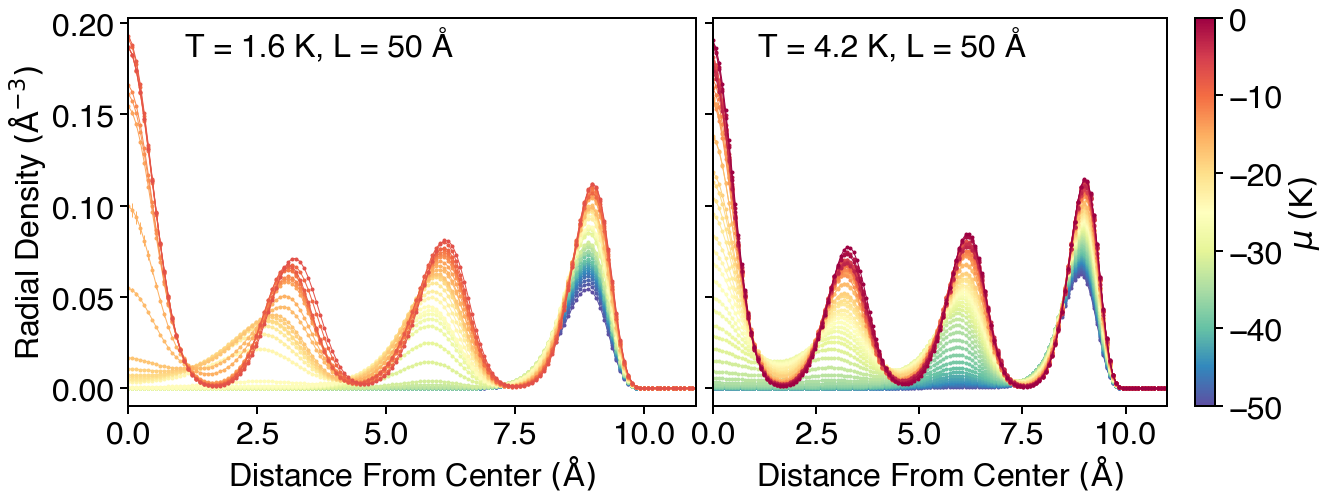

In [11]:
fig, axes = plt.subplots(1,2,sharex=False, sharey=True, squeeze=True, figsize=(10,3.5))
fig.subplots_adjust(wspace=0.03)
μmin = -50
colors2 = colortools.get_linear_colors('Spectral',len(μ[Tkey(4.2)][μ[Tkey(4.2)]>μmin]),reverse=True)

for i,cT in enumerate(T):
    idx = 0
    for j,param in enumerate(radρ[Tkey(cT)].params[::-1]):
        if float(param.split('=')[-1]) > μmin:
            axes[i].errorbar(*radρ[Tkey(cT)].epdata(param), marker='o', lw=0.5, ms=1,
                     color=colors2[idx], label=r'$\mu={:f}$'.format(μ[Tkey(cT)][idx]))
            idx += 1

    axes[i].annotate(f'T = {cT:3.1f} K, L = {L:d} Å', xy=(0.1,0.9), xytext=(0.1,0.9),xycoords=axes[i].transAxes, fontsize=16)
    axes[i].set_xlabel(r'Distance From Center $(\mathrm{\AA})$')
    axes[i].set_xlim(0,11);
    axes[i].xaxis.set_major_locator(ticker.MultipleLocator(2.5))

axes[0].set_ylabel(r'Radial Density $(\mathrm{\AA}^{-3})$')

# create the colorbar
sm = plt.cm.ScalarMappable(cmap=mpl.cm.Spectral_r, norm=plt.Normalize(vmin=μ[Tkey(cT)][0], vmax=μmin))
sm._A = []
plt.colorbar(sm, label=r'$\mu\; (\mathrm{K})$')
#plt.savefig('../Output/rho_vs_r.png',dpi=300)

## Save this data in an easily plot-able format

In [12]:
save_files = True

radial_density = {}
if save_files:
    for i,cT in enumerate(T):
        radial_density[Tkey(cT)] = radρ[Tkey(cT)].data
           
    with open('./data/radial_density.pickle', 'wb') as pfile:
        pickle.dump(radial_density, pfile, pickle.HIGHEST_PROTOCOL)
    with open('./data/chemical_potential.pickle', 'wb') as pfile:
        pickle.dump(μ, pfile, pickle.HIGHEST_PROTOCOL)

## The Linear Density and Coverage Inside the Pore

In [13]:
from scipy import integrate
from scipy.signal import argrelextrema

In [43]:
ρshell = {} 
NvdW_frac = {}
rvdw = 1.4 # Å

r_min,r_max = {},{}
ρ_min = {}

for cT in T:
    
    # find the location of the minimas
    data = radρ[Tkey(cT)].epdata(radρ[Tkey(cT)].params[0])
    idx_min = argrelextrema(data[1], np.less)[0]
    rmin = data[0][idx_min]
    r_min[Tkey(cT)] = rmin
    ρ_min[Tkey(cT)] = data[1][idx_min]/data[1][0]
    #print(rmin)
    ρshell[Tkey(cT)] = np.zeros([len(μ[Tkey(cT)]),len(rmin)+1])
    NvdW_frac[Tkey(cT)] = np.zeros([len(μ[Tkey(cT)])])
    
    # and maximas
    idx_max = argrelextrema(data[1], np.greater)[0]
    rmax = data[0][idx_max]
    r_max[Tkey(cT)] = rmax
    #print(rmax)
    
    # the various ranges over which we will integrate
    r = data[0]
    r_range = [r < rmin[0],(r >= rmin[0]) & (r < rmin[1]), (r >= rmin[1]) & (r < rmin[2]), r >= rmin[2]]
  
    for i,param in enumerate(radρ[Tkey(cT)].params):
        
        # find the location of the first minimum
        r = radρ[Tkey(cT)].x(param)
        ρr = radρ[Tkey(cT)].y(param)
        
        for ir,cr in enumerate(r_range):
            ρshell[Tkey(cT)][i][ir] = integrate.simps(r[cr]*ρr[cr],r[cr])*2*π
            if ir > 0:
                ρshell[Tkey(cT)][i][ir] /= 2.0*π*rmax[ir-1]
            else:    
                # The fraction falling inside the virst vdW radius
                vdw_cr = r <= rvdw
                if ρshell[Tkey(cT)][i][ir] > 1E-6:
                    NvdW_frac[Tkey(cT)][i] = integrate.simps(r[vdw_cr]*ρr[vdw_cr],r[vdw_cr])*2*π / ρshell[Tkey(cT)][i][ir]
                else:
                    NvdW_frac[Tkey(cT)][i] = 0.0

        

### Data for Table III in the main text

In [45]:
from ipywidgets import *
import pandas as pd
from IPython.display import display, Markdown

for cT in T:
    df = pd.DataFrame({"R_min":r_min[Tkey(cT)], "R_max":r_max[Tkey(cT)],'ρ_min (Å^{-3})':ρ_min[Tkey(cT)]})
    df.index.name = 'Shell Number'
    df.style.set_caption(Tkey(cT))
    print(Tkey(cT))
    display(Markdown(df.to_markdown()))

T = 1.6 K


|   Shell Number |   R_min |   R_max |   ρ_min (Å^{-3}) |
|---------------:|--------:|--------:|-----------------:|
|              0 |   1.706 |   3.257 |       0.00656078 |
|              1 |   4.575 |   6.126 |       0.012285   |
|              2 |   7.522 |   8.996 |       0.00491553 |

T = 4.2 K


|   Shell Number |   R_min |   R_max |   ρ_min (Å^{-3}) |
|---------------:|--------:|--------:|-----------------:|
|              0 |   1.706 |   3.257 |       0.00627529 |
|              1 |   4.653 |   6.204 |       0.0116497  |
|              2 |   7.522 |   8.996 |       0.0041766  |

## Save coverage and density data to disk 

In [46]:
save_files = True

if save_files:           
    with open('./data/coverage.pickle', 'wb') as pfile:
        pickle.dump(ρshell, pfile, pickle.HIGHEST_PROTOCOL)

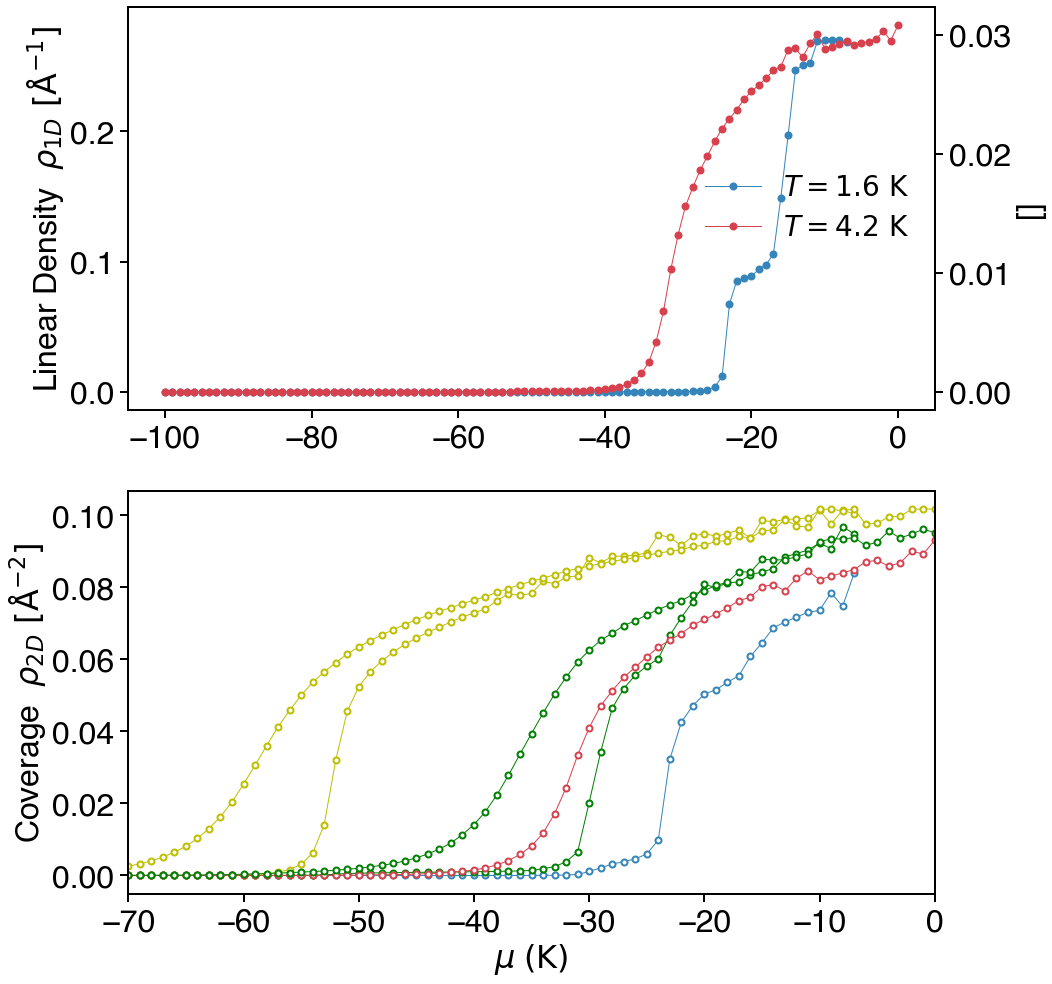

In [48]:
fig, axes = plt.subplots(2,1,sharex=False, sharey=False, squeeze=True, figsize=(7,8))
fig.subplots_adjust(wspace=0.03)

for i,cT in enumerate(T):
    axes[0].plot(μ[Tkey(cT)],ρshell[Tkey(cT)][:,0],marker='o', color=Tcolors[Tkey(cT)], markersize=3, lw=0.5, 
                 label=f'$T = {cT}\ \mathrm{{K}}$')

    
    axes[1].plot(μ[Tkey(cT)],ρshell[Tkey(cT)][:,1],marker='o', color=Tcolors[Tkey(cT)], mfc='w', markersize=3, lw=0.5)
    
    axes[1].plot(μ[Tkey(cT)],ρshell[Tkey(cT)][:,2],marker='o', color='green', mfc='w', markersize=3, lw=0.5, label=r'$r < 5.0\, \mathrm{\AA}$')
    
    axes[1].plot(μ[Tkey(cT)],ρshell[Tkey(cT)][:,3],marker='o', color='y', mfc='w', markersize=3, lw=0.5, label=r'$r < 5.0\, \mathrm{\AA}$')

    #    axes[i].text(-48,2.75,'T = {:4.1f} K, L = {:d} Å'.format(cT,L),fontsize=18)

ax2 = axes[0].twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot([-1,0],[0,ρshell[Tkey(cT)][0,0]/(π*1.706*1.706)], marker='None', ls='None')
ax2.set_ylabel([]) 
#     ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
#     ax2.plot(t, data2, color=color)
#     ax2.tick_params(axis='y', labelcolor=color)

#plt.plot(μ,ρlin[:,2],marker='o', markersize=3, lw=0.5, label=r'$r < 7.5\, \mathrm{\AA}$')

axes[-1].set_xlim(-70,0)
axes[-1].set_xlabel(r'$\mu\; (\mathrm{K})$')

axes[0].set_ylabel(r'Linear Density  $\rho_{1D}\ [\mathrm{\AA}^{-1}]$')

axes[1].set_ylabel(r'Coverage  $\rho_{2D}\ [\mathrm{\AA}^{-2}]$')
axes[0].legend(loc='center right', frameon=False)
#plt.savefig('../Output/rholinear_vs_r.png',dpi=300)

[]

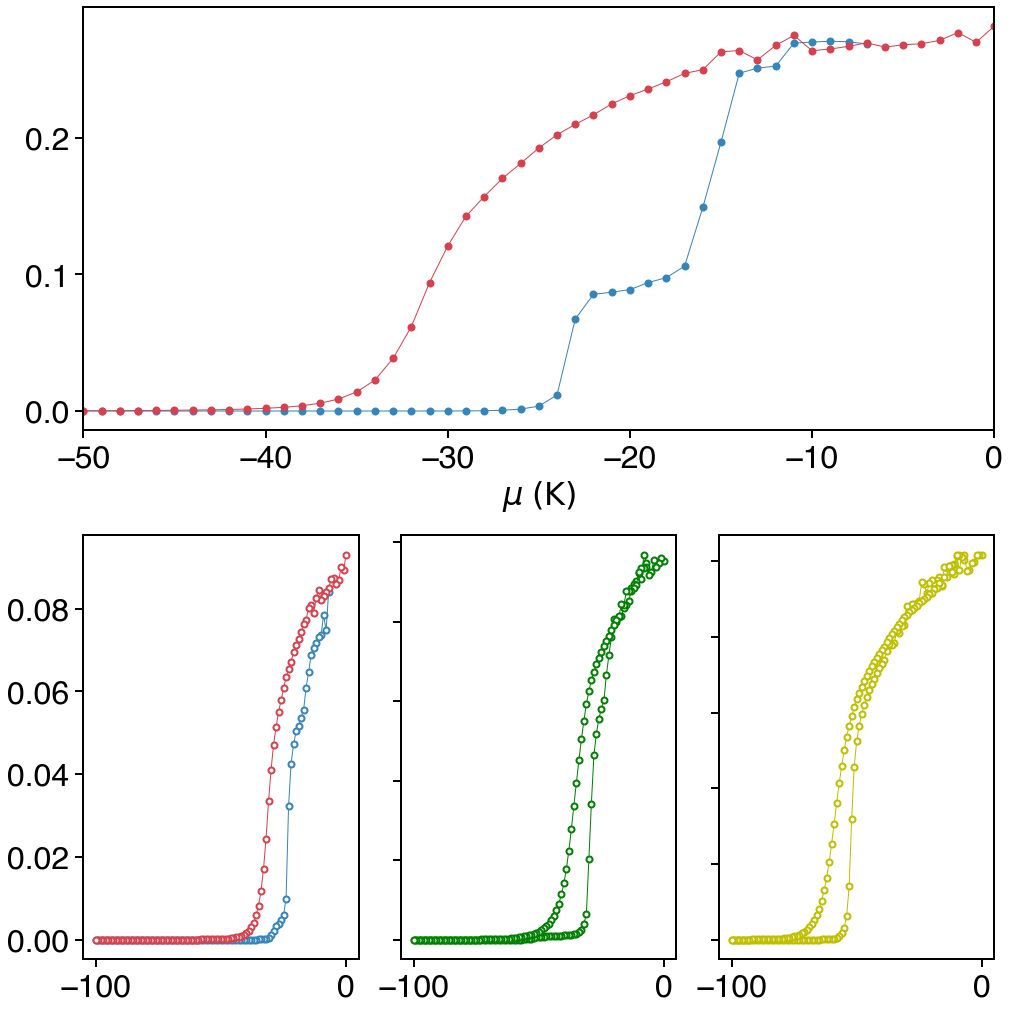

In [50]:
fig = plt.figure(figsize=(7,7),constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=3)
ax = [fig.add_subplot(gs[0, :])]
for i in range(3):
    ax.append(fig.add_subplot(gs[1,i]))
    
labels = ['core','1st shell', '2nd shell', '3rd shell']
for i,cT in enumerate(T):
    ax[0].plot(μ[Tkey(cT)],ρshell[Tkey(cT)][:,0],marker='o', color=Tcolors[Tkey(cT)], markersize=3, lw=0.5, 
                 label=f'$T = {cT}\ \mathrm{{K}}$')
    
    ax[1].plot(μ[Tkey(cT)],ρshell[Tkey(cT)][:,1],marker='o', color=Tcolors[Tkey(cT)], mfc='w', markersize=3, lw=0.5)
    ax[2].plot(μ[Tkey(cT)],ρshell[Tkey(cT)][:,2],marker='o', color='green', mfc='w', markersize=3, lw=0.5, label=r'$r < 5.0\, \mathrm{\AA}$')
    ax[3].plot(μ[Tkey(cT)],ρshell[Tkey(cT)][:,3],marker='o', color='y', mfc='w', markersize=3, lw=0.5, label=r'$r < 5.0\, \mathrm{\AA}$')
    
ax[0].set_xlim(-50,0)
ax[0].set_xlabel(r'$\mu\; (\mathrm{K})$')
ax[2].set_yticklabels([])
ax[3].set_yticklabels([])

### Investigate the fration falling within the van der Waals radius

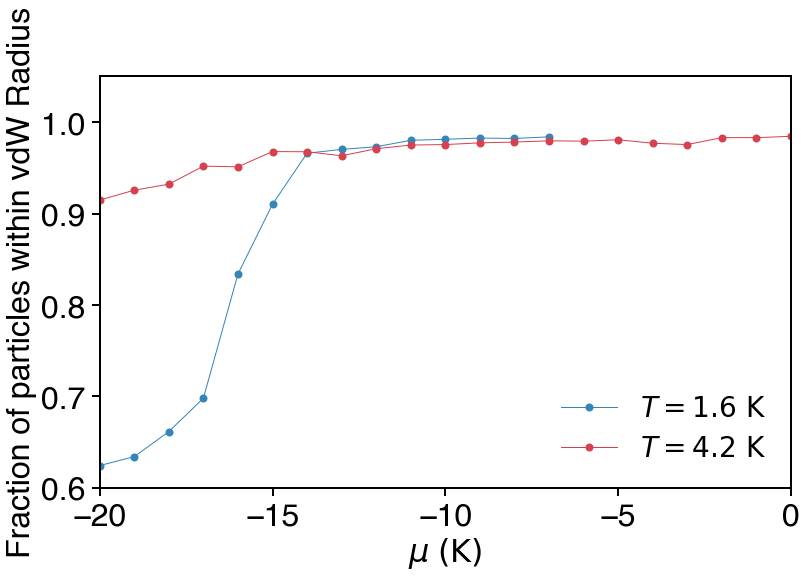

In [51]:
fig, axes = plt.subplots(1,1,sharex=False, sharey=False, squeeze=True)
fig.subplots_adjust(wspace=0.03)

for i,cT in enumerate(T):
    axes.plot(μ[Tkey(cT)],NvdW_frac[Tkey(cT)],marker='o', color=Tcolors[Tkey(cT)], markersize=3, lw=0.5, 
                 label=f'$T = {cT}\ \mathrm{{K}}$')
    

axes.set_xlim(-20,0)
axes.set_ylim(0.6,1.05)

axes.set_ylabel('Fraction of particles within vdW Radius')
axes.set_xlabel(r'$\mu\; (\mathrm{K})$')
axes.legend()

## The Wall Potential

In [16]:
data = np.loadtxt('/Users/agdelma/Documents/UVM/Projects/PIMC/OUTPUT/gce-debug-02.000-010.000--011.000-0.04000-421fb4f8-d36a-46b4-95e5-0c38c693a3cb.dat')

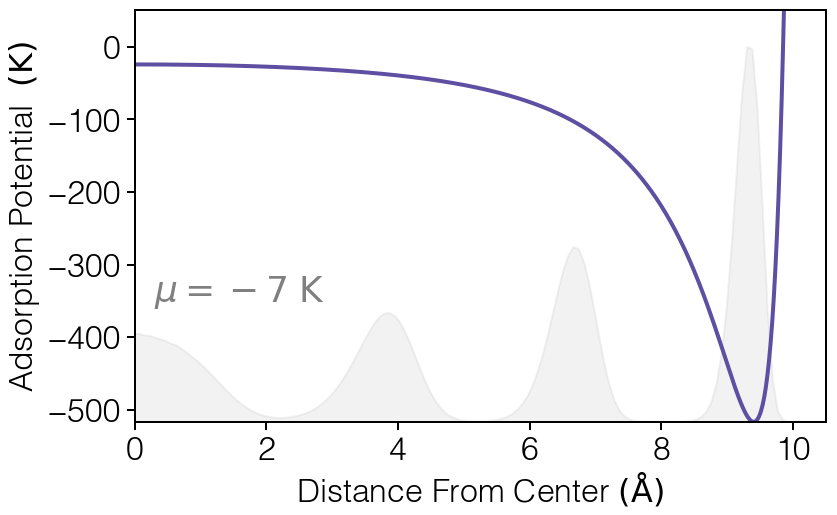

In [17]:
plt.plot(data[:,0],data[:,1])
cdata = -radρ[Tkey(1.6)].y(radρ[Tkey(1.6)].params[0])/np.max(radρ[Tkey(1.6)].y(radρ[Tkey(1.6)].params[0]))*np.min(data[:,1]) + np.min(data[:,1])
plt.fill_between(radρ[Tkey(1.6)].x(radρ[Tkey(1.6)].params[0]),np.min(data[:,1]),cdata, color='gray', alpha=0.1)
plt.xlim(0,10.5)
plt.ylim(np.min(data[:,1]),50)
plt.text(0.3,-350,r'$\mu=-7\; \mathrm{K}$', color='gray', fontsize=18)
plt.xlabel(r'Distance From Center $(\mathrm{\AA})$')
plt.ylabel(r'Adsorption Potential  $(\mathrm{K})$');
plt.savefig('../Output/V_vs_r.png',dpi=300)

## Superfluid Density

In [18]:
ρs = PIMCResults('../../../Data/Nanopores/super-u-reduce-T-01.600-t-0.00400-L-050.000.dat')

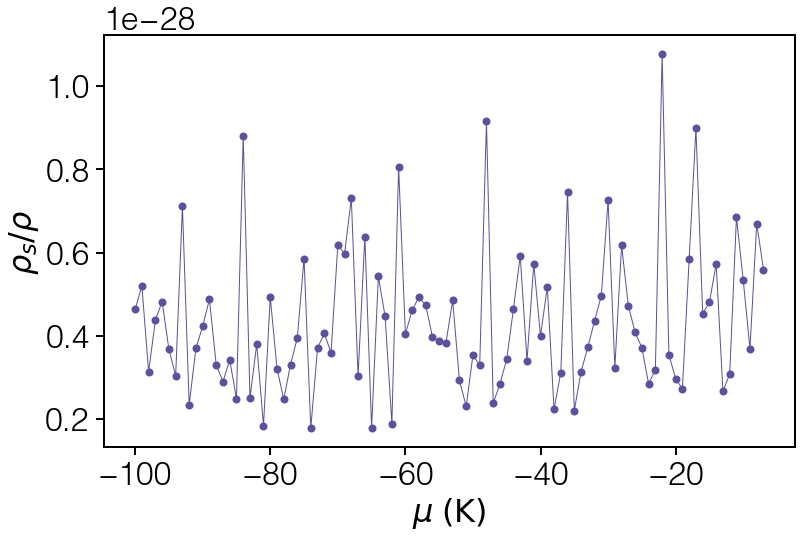

In [19]:
plt.plot(ρs.data['u'],ρs.data['rho_s/rho'],marker='o', markersize=3, lw=0.5)
plt.xlabel(r'$\mu\; (\mathrm{K})$')
plt.ylabel(r'$\rho_s/\rho$');

In [1]:
import numpy as np

In [3]:
a = np.array([[1,3],[-1,8]])

In [4]:
a

array([[ 1,  3],
       [-1,  8]])

In [5]:
a.sort(axis=0)

In [6]:
a

array([[-1,  3],
       [ 1,  8]])

In [7]:
a.sort(axis=1)

In [8]:
a

array([[-1,  3],
       [ 1,  8]])

In [9]:
a = np.array([[1,3],[-1,8]])

In [10]:
a.sort(axis=1)

In [11]:
a

array([[ 1,  3],
       [-1,  8]])

In [12]:
a = np.array([[1,3],[-3,8],[-1,4]])

In [13]:
a

array([[ 1,  3],
       [-3,  8],
       [-1,  4]])

In [14]:
a.sort(axis=0)

In [15]:
a

array([[-3,  3],
       [-1,  4],
       [ 1,  8]])